# Nemo 3D tutorial


One of the features of Parcels is that it can directly and natively work with `Field` data discretised on C-grids. These C grids are very popular in OGCMs, so velocity fields outputted by OGCMs are often provided on such grids, except if they have been firstly re-interpolated on a A grid.

More information about C-grid interpolation can be found in [Delandmeter et al., 2019](https://www.geosci-model-dev-discuss.net/gmd-2018-339/).
An example of such a discretisation is the NEMO model, which is one of the models supported in Parcels. A tutorial teaching how to [interpolate 2D data on a NEMO grid](https://docs.oceanparcels.org/en/latest/examples/tutorial_nemo_curvilinear.html) is available within Parcels.

Here, we focus on 3D fields. Basically, it is a straightforward extension of the 2D example, but it is very easy to do a mistake in the setup of the vertical discretisation that would affect the interpolation scheme.

## Preliminary comments

_How to know if your data is discretised on a C grid?_ The best way is to read the documentation that comes with the data. Alternatively, an easy check is to assess the coordinates of the U, V and W fields: for an A grid, U, V and W are distributed on the same nodes, such that the coordinates are the same. For a C grid, there is a shift of half a cell between the different variables.

_What about grid indexing?_ Since the C-grid variables are not located on the same nodes, there is not one obvious way to define the indexing, i.e. where is `u[k,j,i]` compared to `v[k,j,i]` and `w[k,j,i]`. In Parcels, we use the same notation as in NEMO: see [horizontal indexing](https://www.nemo-ocean.eu/doc/img360.png) and [vertical indexing](https://www.nemo-ocean.eu/doc/img362.png).
It is important that you check if your data is following the same notation. Otherwise, you should re-index your data properly (this can be done within Parcels, there is no need to regenerate new netcdf files).

_What about the accuracy?_ By default in Parcels, particle coordinates (i.e. longitude, latitude and depth) are stored using single-precision `np.float32` numbers. The advantage of this is that it saves some memory resources for the computation. In some applications, especially where particles travel very close to the coast, the single precision accuracy can lead to uncontrolled particle beaching, due to numerical rounding errors. In such case, you may want to double the coordinate precision to `np.float64`. This can be done by adding the parameter `lonlatdepth_dtype=np.float64` to the ParticleSet constructor. Note that for C-grid fieldsets such as in NEMO, the coordinates precision is set by default to `np.float64`.

## How to create a 3D NEMO `dimensions` dictionary?

In the following, we will show how to create the `dimensions` dictionary for 3D NEMO simulations. What you require is a 'mesh_mask' file, which in our case is called `coordinates.nc` but in some other versions of NEMO has a different name. In any case, it will have to contain the variables `glamf`, `gphif` and `depthw`, which are the longitude, latitude and depth of the mesh nodes, respectively. Note that `depthw` is not part of the mesh_mask file, but is in the same file as the w data (`wfiles[0]`).

For the C-grid interpolation in Parcels to work properly, it is important that `U`, `V` and `W` are on the same grid.

The code below is an example of how to create a 3D simulation with particles, starting in the mouth of the river Rhine at 1m depth, and advecting them through the North Sea using the `AdvectionRK4_3D`


In [1]:
from datetime import timedelta as delta
from glob import glob

import matplotlib.pyplot as plt
import xarray as xr

from parcels import (
    AdvectionRK4_3D,
    FieldSet,
    JITParticle,
    ParticleSet,
    XarrayDecodedFilter,
    download_example_dataset,
    logger,
)

# Add a filter for the xarray decoding warning
logger.addFilter(XarrayDecodedFilter())

example_dataset_folder = download_example_dataset("NemoNorthSeaORCA025-N006_data")
ufiles = sorted(glob(f"{example_dataset_folder}/ORCA*U.nc"))
vfiles = sorted(glob(f"{example_dataset_folder}/ORCA*V.nc"))
wfiles = sorted(glob(f"{example_dataset_folder}/ORCA*W.nc"))
mesh_mask = f"{example_dataset_folder}/coordinates.nc"

filenames = {
    "U": {"lon": mesh_mask, "lat": mesh_mask, "depth": wfiles[0], "data": ufiles},
    "V": {"lon": mesh_mask, "lat": mesh_mask, "depth": wfiles[0], "data": vfiles},
    "W": {"lon": mesh_mask, "lat": mesh_mask, "depth": wfiles[0], "data": wfiles},
}

variables = {"U": "uo", "V": "vo", "W": "wo"}

# Note that all variables need the same dimensions in a C-Grid
c_grid_dimensions = {
    "lon": "glamf",
    "lat": "gphif",
    "depth": "depthw",
    "time": "time_counter",
}
dimensions = {
    "U": c_grid_dimensions,
    "V": c_grid_dimensions,
    "W": c_grid_dimensions,
}

fieldset = FieldSet.from_nemo(filenames, variables, dimensions)

pset = ParticleSet.from_line(
    fieldset=fieldset,
    pclass=JITParticle,
    size=10,
    start=(1.9, 52.5),
    finish=(3.4, 51.6),
    depth=1,
)

kernels = pset.Kernel(AdvectionRK4_3D)
pset.execute(kernels, runtime=delta(days=4), dt=delta(hours=6))

100%|██████████| 345600.0/345600.0 [00:00<00:00, 55244158.02it/s]


Level[8] depth is: [10.7679 12.846]


/var/folders/1n/500ln6w97859_nqq86vwpl000000gr/T/ipykernel_56153/3089997373.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(


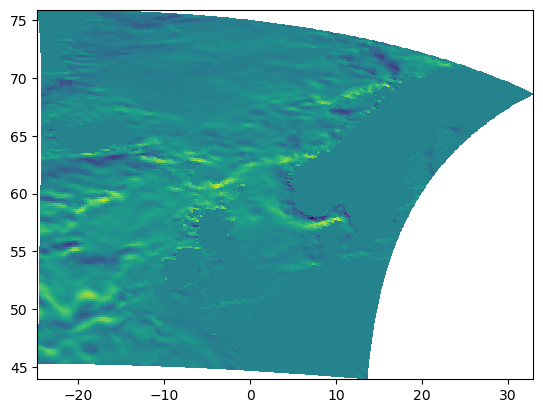

In [2]:
depth_level = 8
print(
    f"Level[{int(depth_level)}] depth is: "
    f"[{fieldset.W.grid.depth[depth_level]:g} "
    f"{fieldset.W.grid.depth[depth_level+1]:g}]"
)

plt.pcolormesh(
    fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0, depth_level, :, :]
)
plt.show()

## Adding other fields like cell edges

It is quite straightforward to add other gridded data, on the same curvilinear or any other type of grid, to the fieldset. Because it is good practice to make no changes to a `FieldSet` once a `ParticleSet` has been defined in it, we redefine the fieldset and add the fields with the cell edges from the coordinates file using `FieldSet.add_field()`.


In [3]:
from parcels import Field

In [4]:
fieldset = FieldSet.from_nemo(filenames, variables, dimensions)

In [5]:
e1u = Field.from_netcdf(
    filenames=mesh_mask,
    variable="e1u",
    dimensions={"lon": "glamu", "lat": "gphiu"},
    interp_method="nearest",
)
e2u = Field.from_netcdf(
    filenames=mesh_mask,
    variable="e2u",
    dimensions={"lon": "glamu", "lat": "gphiu"},
    interp_method="nearest",
)
e1v = Field.from_netcdf(
    filenames=mesh_mask,
    variable="e1v",
    dimensions={"lon": "glamv", "lat": "gphiv"},
    interp_method="nearest",
)
e2v = Field.from_netcdf(
    filenames=mesh_mask,
    variable="e2v",
    dimensions={"lon": "glamv", "lat": "gphiv"},
    interp_method="nearest",
)
fieldset.add_field(e1u)
fieldset.add_field(e2u)
fieldset.add_field(e1v)
fieldset.add_field(e2v)